In [52]:
import numpy as np
from scipy import constants
from scipy.optimize import leastsq
import uncertainties
from uncertainties import unumpy as unp
from matplotlib import pyplot as plt
%matplotlib inline

Molar masses

In [2]:
N0 = 70
M = {
    'P':31, 'N':14, 'C':12, 'O':8, 'H':1, 
    'F':19, 'Cl':35.5, 'Br':80, 'I':127}
M['head_Ph'] = 6 * M['C'] + 5 * M['O'] + 10 * M['H'] + M['P']
M['head_Et'] = 6 * M['C'] + 2 * M['O'] + 11 * M['H']
M['monoBr'] = 5 * M['C'] + 2 * M['O'] + 7 * M['H'] + M['Br']
M['Imidazolium'] = 4 * M['C'] + 6 * M['H'] + 2 * M['N']
M['Pyrrolidinium'] = 5 * M['C'] + 11 * M['H'] + M['N']
for short, full in [('Im', 'Imidazolium'), ('Pyr', 'Pyrrolidinium')]:
    for X in ['F','Cl','Br','I']:
        M['P'+short+X] = M['head_Ph'] + N0 * (M['monoBr'] + M[full] - M['Br'] + M[X])
        M['P'+short+X+'_Et'] = M['head_Et'] + N0 * (M['monoBr'] + M[full] - M['Br'] + M[X])

In [3]:
M

{'Br': 80,
 'C': 12,
 'Cl': 35.5,
 'F': 19,
 'H': 1,
 'I': 127,
 'Imidazolium': 82,
 'N': 14,
 'O': 8,
 'P': 31,
 'PImBr': 17303,
 'PImBr_Et': 17249,
 'PImCl': 14188.0,
 'PImCl_Et': 14134.0,
 'PImF': 13033,
 'PImF_Et': 12979,
 'PImI': 20593,
 'PImI_Et': 20539,
 'PPyrBr': 17513,
 'PPyrBr_Et': 17459,
 'PPyrCl': 14398.0,
 'PPyrCl_Et': 14344.0,
 'PPyrF': 13243,
 'PPyrF_Et': 13189,
 'PPyrI': 20803,
 'PPyrI_Et': 20749,
 'Pyrrolidinium': 85,
 'head_Et': 99,
 'head_Ph': 153,
 'monoBr': 163}

From now on, in dissociation order: PImBr, PImI, PPyrCl, PPyrBr, PPyrI

Monomer number density for a weight fraction of 80 g/kg

In [4]:
names = ['PImBr', 'PImI', 'PPyrCl', 'PPyrBr', 'PPyrI']
w = 80
c = N0 * constants.N_A / np.array([M[s] for s in names]) * 80 * 1000

Load strain sweeps at $f=1$ Hz.

In [5]:
sweeps = [
    np.loadtxt('ImBr_70_PO3_8pc_bis.strain', skiprows=5, usecols=[4,6,7]),
    np.loadtxt('PImI0CL70unit_80gperL.strain', skiprows=2),
    np.loadtxt('PPyCl0CL70unit_80gperL.strain', skiprows=2),
    np.loadtxt('PPyBr_70_0pc.strain', skiprows=5, usecols=[4,6,7])[:20],
    np.loadtxt('PPyI0CL70unit_80gperL_bis.strain', skiprows=5, usecols=[4,6,7]),
    ]

Measure $G'(\gamma \rightarrow 0)$ and the error

In [6]:
G = unp.uarray(
    [a[0,1] for a in sweeps],
    np.abs([(a[0,1]-a[1,1])/2 for a in sweeps])
)
for name, g in zip(names, G):
    print('{}:\tG\' = {:10.4P} Pa\trelative error: {:0.2f}%'.format(name,g,100*g.s/g.n))

PImBr:	G' =      13.28±      0.19 Pa	relative error: 1.43%
PImI:	G' =      78.56±      0.13 Pa	relative error: 0.17%
PPyrCl:	G' =      272.3±       0.6 Pa	relative error: 0.20%
PPyrBr:	G' =       9811±        40 Pa	relative error: 0.40%
PPyrI:	G' =       8796±        34 Pa	relative error: 0.38%


Measure the critical strain $\gamma_c$ such that $G''$ is maximum, and the error.

In [7]:
imaxs = np.array([np.argmax(a[:,2]) for a in sweeps])
gamma_c = unp.uarray(
    [np.exp((np.log(a[imax,0])+np.log(a[imax+1,0]))/2) for a,imax in zip(sweeps, imaxs)],
    [(a[imax+1,0]-a[imax,0])/2 for a,imax in zip(sweeps, imaxs)]
    )
for name, g in zip(names, gamma_c):
    print('{}:\tgamma_c\' = {:10P}\trelative error: {:0.2f}%'.format(name,g,100*g.s/g.n))

PImBr:	gamma_c' =        9.0±       1.0	relative error: 11.53%
PImI:	gamma_c' =      0.180±     0.024	relative error: 13.40%
PPyrCl:	gamma_c' =       0.18±      0.15	relative error: 83.32%
PPyrBr:	gamma_c' =      0.029±     0.018	relative error: 61.88%
PPyrI:	gamma_c' =      0.044±     0.005	relative error: 11.33%


## Cross-linked gel

The shear modulus of a cross-linked gel is given by:
$$G = \frac{c}{N}k_\mathrm{B}T,$$
with $N$ the number of monomers between cross-links. Conversly, we can get the number $n = N/N_0$ of chains between cross-links:

In [8]:
T = constants.C2K(25)
n = c/N0 * constants.k * T / G
for name, g in zip(names, n):
    print('{}:\tn = {:10P}\trelative error: {:0.2f}%'.format(name,g,100*g.s/g.n))

PImBr:	n =        863±        12	relative error: 1.43%
PImI:	n =     122.59±      0.20	relative error: 0.17%
PPyrCl:	n =      50.58±      0.10	relative error: 0.20%
PPyrBr:	n =      1.154±     0.005	relative error: 0.40%
PPyrI:	n =      1.084±     0.004	relative error: 0.38%


If head-to-body bonds break within the linear regime of the chain, the bonding energy can be deduced from the critical strain:
$$\frac{E_c}{k_\mathrm{B}T} = \gamma_c^2$$

In [9]:
for name, g in zip(names, gamma_c**2):
    print('{}:\tE_c = {:10P} kT = {:10.3P} kJ/mol \trelative error: {:0.2f}%'.format(
            name, g, 
            g * constants.k * T * constants.N_A / 1000,
            100*g.s/g.n))

PImBr:	E_c =         81±        19 kT =        202±        47 kJ/mol 	relative error: 23.06%
PImI:	E_c =      0.032±     0.009 kT =     0.0802±    0.0215 kJ/mol 	relative error: 26.81%
PPyrCl:	E_c =       0.03±      0.05 kT =      0.082±     0.136 kJ/mol 	relative error: 166.64%
PPyrBr:	E_c =     0.0009±    0.0011 kT =    0.00214±   0.00265 kJ/mol 	relative error: 123.76%
PPyrI:	E_c =     0.0020±    0.0004 kT =    0.00488±   0.00111 kJ/mol 	relative error: 22.66%


Only PImBr has $E_c>k_\mathrm{B}T$.

### Estimation of extension parameter $B$

In abscence of salt, the screening length is
$$r_\mathrm{scr} = \left(\frac{B}{cb}\right)^{1/2}$$
where $b\approx 0.26$ nm is the monomer size and $B$ is the extension parameter
$$B = \frac{b g_e}{D} = \frac{b g_\mathrm{src}}{r_\mathrm{src}}$$
describes the electrostatic blob of diameter $D$ containing $g_e$ monomers. Between $D$ and $r_\mathrm{scr}$ the polyelectrolyte is a linear assembly of electrostatic blobs, thus
$$g_\mathrm{src} = g_e \frac{r_\mathrm{src}}{D} = \left(\frac{B^3}{cb^3}\right)^{1/2}$$.

The exit from the linear domain of the material corresponds to the full extension of the persistent random walk:
$$\gamma_c = \frac{R_0}{R} - 1,$$
with
$$\left. \begin{array}{ll}
R &= r_\mathrm{scr} \left(\frac{N}{g_\mathrm{scr}}\right)^{1/2}\\
R_0 &= r_\mathrm{scr} \frac{N}{g_\mathrm{scr}}
\end{array}\right\rbrace\quad
\gamma_c = \left(\frac{N}{g_\mathrm{scr}}\right)^{1/2} -1
$$

Finally
$$B = \left(b^3 c \frac{N^2}{(\gamma_c+1)^4}\right)^{1/3} = bc \left(\frac{k_\mathrm{B}T}{G\left(\gamma_c+1\right)^2}\right)^{2/3}$$

In [10]:
b = 0.26e-9
B = b * c * (constants.k * T / G / (gamma_c+1)**2)**(2/3)
for name, g in zip(names, B):
    print('{}:\tB = {:10P} \trelative error: {:0.2f}%'.format(name,g,100*g.s/g.n))

PImBr:	B =       10.7±       1.5 	relative error: 13.87%
PImI:	B =       47.8±       1.3 	relative error: 2.73%
PPyrCl:	B =         30±         5 	relative error: 17.08%
PPyrBr:	B =       2.70±      0.06 	relative error: 2.37%
PPyrI:	B =      2.398±     0.017 	relative error: 0.69%


PImBr is set aside because head-to-body link broke before full extension of the persistent random walk.

Conversly, 
$$\gamma_c = \left(\frac{N^2 c b^3}{B^3}\right)^{1/4} -1 = \left(\frac{k_\mathrm{B}T}{G}\right)^{1/2}\left(\frac{cb}{B}\right)^{3/4} -1$$

We know that PImBr has even less charges than than PImI, so we assume a $B$ at least equal in PImBr with respect to PImI
$$\gamma_c(\mathrm{PImBr}) < \left(\frac{k_\mathrm{B}T}{G(\mathrm{PImBr})}\right)^{1/2}\left(\frac{c(\mathrm{PImBr})b}{B(\mathrm{PImI})}\right)^{3/4} -1$$

In [11]:
g = (constants.k * T / G[0])**(1/2) * (c[0] * b / B[1])**(3/4)-1
print('gamma_c_max = {:P}\trelative error:  {:0.2f}%'.format(g,100*g.s/g.n))
print('but gamma_c = {:P}'.format(gamma_c[0]))

gamma_c_max = 2.27±0.07	relative error:  3.12%
but gamma_c = 9.0±1.0


Therefore PImBr has a linear regime much larger than what we expect.

### Estimation of the charge density

From the extension parameter $B$ and provided an assumption on the $\Theta$-temperature, we can deduce the number $A$ of monomers between dissociated charges. If $A=1$, there is no counterion condensation and the polyelectrolyte is fully charged.
$$B = \left(\frac{A^2}{u}\right)^{2/3}\tau \Leftrightarrow A = u^{1/2} \left(\frac{B}{\tau}\right)^{3/4}$$
where $u = b/\ell_\mathrm{B}$, with $\ell_\mathrm{B} = 0.7$ nm the Bjerrum length in water and $\tau = 1-T/\Theta$ the reduced temperature. We know that $\Theta>100$C so $0.2<\tau<1$.

In [12]:
lB = 0.7e-9
u = lB/b
tau = 0.2
A = u**(1/2) * (B/tau)**(3/4)
for name, g in zip(names, A):
    print('{}:\tA = {:10P} \trelative error: {:0.2f}%'.format(name,g,100*g.s/g.n))

PImBr:	A =       32.6±       3.4 	relative error: 10.40%
PImI:	A =       99.8±       2.0 	relative error: 2.05%
PPyrCl:	A =         70±         9 	relative error: 12.81%
PPyrBr:	A =      11.56±      0.21 	relative error: 1.78%
PPyrI:	A =      10.57±      0.05 	relative error: 0.52%


Is it possible to have $A>N_0$?

### Lower bound for $\tau$

for the polymer to be soluble, we want at least a charge per polymer, or $A<N_0$ that yields
$$\tau > \left(\frac{n u}{N_0}\right)^{2/3} \frac{c^{1/3}b}{(\gamma_c+1)^{4/3}}$$

In [13]:
for name, g in zip(names, (n*u/N0)**(2/3) * c**(1/3) * b /(gamma_c+1)**(4/3)):
    print('{}:\ttau_max = {:10P} \trelative error: {:0.2f}%'.format(name,g,100*g.s/g.n))

PImBr:	tau_max =      0.072±     0.010 	relative error: 13.87%
PImI:	tau_max =      0.321±     0.009 	relative error: 2.73%
PPyrCl:	tau_max =      0.200±     0.034 	relative error: 17.08%
PPyrBr:	tau_max =     0.0181±    0.0004 	relative error: 2.37%
PPyrI:	tau_max =    0.01608±   0.00011 	relative error: 0.69%


In [14]:
lB = 0.7e-9
u = lB/b
tau = 0.33
A = u**(1/2) * (B/tau)**(3/4)
for name, g in zip(names, A):
    print('{}:\tA = {:10P} \trelative error: {:0.2f}%'.format(name,g,100*g.s/g.n))

PImBr:	A =       22.4±       2.3 	relative error: 10.40%
PImI:	A =       68.5±       1.4 	relative error: 2.05%
PPyrCl:	A =         48±         6 	relative error: 12.81%
PPyrBr:	A =       7.94±      0.14 	relative error: 1.78%
PPyrI:	A =       7.26±      0.04 	relative error: 0.52%


### Are Phosphonate charges negigible ?

In presence of additional salts in concentration $c_s$, the screening length becomes
$$r_\mathrm{scr} = \left(\frac{B}{cb}\right)^{1/2}\left(1 + B u \frac{c_s}{c}\right)^{-1/2}$$

So we have to estimate $B u c_s/c$ relative to 1 with $c_s/c = 2/N_0$.

In [15]:
for name, g in zip(names, B*u*2/N0):
    print('{}:\t {:10P} \trelative error: {:0.2f}%'.format(name,g,100*g.s/g.n))

PImBr:	       0.83±      0.11 	relative error: 13.87%
PImI:	       3.68±      0.10 	relative error: 2.73%
PPyrCl:	        2.3±       0.4 	relative error: 17.08%
PPyrBr:	      0.208±     0.005 	relative error: 2.37%
PPyrI:	     0.1844±    0.0013 	relative error: 0.69%


### Estimation of extension parameter $B$

When counting the screening from phosphonates, we have to distinguish between the screening length
$$r_\mathrm{scr} = \left(\frac{B}{cb}\right)^{1/2}\left(1 + 2 B u / N_0 \right)^{-1/2}$$
and the correlation length
$$\xi = \left(\frac{B}{cb}\right)^{1/2}\left(1 + 2 B u / N_0 \right)^{1/4}$$
where $b\approx 0.26$ nm is the monomer size and $B$ is the extension parameter
$$B = \frac{b g_e}{D} = \frac{b g_\mathrm{src}}{r_\mathrm{src}}$$
that describes the electrostatic blob of diameter $D$ containing $g_e$ monomers. 

Between $D$ and $r_\mathrm{scr}$ the polyelectrolyte is a linear assembly of electrostatic blobs, thus
$$g_\mathrm{src} = B \frac{r_\mathrm{src}}{b} = \left(\frac{B^3}{cb^3}\right)^{1/2} \left(1 + 2 B u / N_0 \right)^{-1/2}$$

Between the electrostatic screening length and the correlation length $\xi$, the polyelectrolyte chain is a self-avoiding walk. Each correlation blob has $g$ ($=c\xi^3$) monomers in it.
$$g = \left(\frac{B^3}{c b^3}\right)^{1/2} \left(1 + 2 B u / N_0 \right)^{3/4}$$

Beyond the correlation length, the chain statistics are Gaussian. We can thus define a first critical strain corresponding to the full extention of this random walk:
$$\gamma_0 = \frac{R_0}{R} - 1,$$
with
$$\left. \begin{array}{ll}
R &= \xi \left(\frac{N}{g}\right)^{1/2}\\
R_0 &= \xi \frac{N}{g}
\end{array}\right\rbrace\quad
\gamma_0 = \left(\frac{N}{g}\right)^{1/2} -1
$$

The exit from the linear domain of the material corresponds to the full extension of the self avoiding walk of $r_\mathrm{src}$-long rods:
$$\gamma_c = \frac{R_1}{R} - 1,$$
with
$$ R_1 = r_\mathrm{scr} \frac{N}{g_\mathrm{scr}} = D \frac{N}{g_e}$$
thus
$$\gamma_c +1 = \frac{r_\mathrm{scr}}{\xi} \left(\frac{N g}{g_\mathrm{scr}^2}\right)^{1/2} = N^{1/2} \left(\frac{c b^3}{B^3}\right)^{1/4} \left(1 + 2 B u / N_0 \right)^{1/8} = \left(\frac{k_\mathrm{B}T}{G}\right)^{1/2} \left(\frac{c b}{B}\right)^{3/4} \left(1 + 2 B u / N_0 \right)^{1/8}$$

Finally we can solve for B
$$\frac{\left(\gamma_c +1\right)^8}{c^6 b^6}\left(\frac{G}{k_\mathrm{B}T}\right)^4 B^6 = 1 + \frac{2u}{N_0} B$$

In [17]:
N0/(2*u)

12.999999999999998

If $B\ll \frac{N_0}{2u}\approx 13$ phosphonate charges are negligibles and we recover
$$B = c b \left(\frac{k_\mathrm{B}T}{G\left(\gamma_c +1\right)^2}\right)^{2/3}$$

If $B\gg \frac{N_0}{2u}\approx 13$ phosphonate charges are dominant
$$B = \left(cb\right)^{6/5} \left(\frac{2u}{N_0}\right)^{1/5} \left(\frac{k_\mathrm{B}T}{G\left(\gamma_c +1\right)^2}\right)^{4/5}$$

In [18]:
B2 = (b * c)**(6/5) * (2*u/N0)**(1/5) * (constants.k * T / G / (gamma_c+1)**2)**(4/5)
for name, g in zip(names, B2):
    print('{}:\tB = {:10P} \trelative error: {:0.2f}%'.format(name,g,100*g.s/g.n))

PImBr:	B =       10.3±       1.7 	relative error: 16.64%
PImI:	B =       62.0±       2.0 	relative error: 3.27%
PPyrCl:	B =         35±         7 	relative error: 20.50%
PPyrBr:	B =       1.97±      0.06 	relative error: 2.85%
PPyrI:	B =      1.710±     0.014 	relative error: 0.83%


In the phosphonate dominated case 
$$\gamma_c +1 \approx \left(\frac{k_\mathrm{B}T}{G}\right)^{1/2} \left(c b\right)^{3/4} \left(\frac{2 u}{N_0} \right)^{1/8} B^{-5/8}$$

We know that PImBr has even less charges than than PImI, so we assume a $B$ at least equal in PImBr with respect to PImI
$$\gamma_c(\mathrm{PImBr}) < \left(\frac{k_\mathrm{B}T}{G(\mathrm{PImBr})}\right)^{1/2} \left(c(\mathrm{PImBr}) b\right)^{3/4} \left(\frac{2 u}{N_0} \right)^{1/8} B(\mathrm{PImI})^{-5/8}-1$$

In [28]:
for name, g in zip(names, (constants.k * T / G[0])**(1/2) * (c[0] * b)**(3/4) * (2*u/N0)**(1/8) / B2**(5/8) - 1):
    print('{}:\tgamma_c_max = {:P}\trelative error:  {:0.2f}%'.format(name,g,100*g.s/g.n))
print('but gamma_c = {:P}'.format(gamma_c[0]))

PImBr:	gamma_c_max = 9.0±1.0	relative error:  11.53%
PImI:	gamma_c_max = 2.27±0.07	relative error:  3.12%
PPyrCl:	gamma_c_max = 3.7±0.6	relative error:  16.33%
PPyrBr:	gamma_c_max = 27.2±0.5	relative error:  1.99%
PPyrI:	gamma_c_max = 29.86±0.27	relative error:  0.91%
but gamma_c = 9.0±1.0


Actually solve for $B$

In [57]:
@uncertainties.wrap
def f(n=0, *P):
    ''' compute the nth root of the polynomial P and the uncertainty of the root'''
    p =  np.array(P)
    N = len(p)
    
    M = np.diag(np.ones((N-2,), p.dtype), -1)
    M[0, :] = -p[1:] / p[0]
    r = np.linalg.eigvals(M)
    r.sort()  # there is no telling what order the values come out in
    return r[n]

In [70]:
B3 = np.array([
        f(5, 1,0,0,0,0,-b1**5,-b0**6)
        for b0,b1 in zip(B,B2)
        ])
for name, g in zip(names, B3):
    print('{}:\tB = {:P}'.format(name,g))

PImBr:	B = 12.0±1.8
PImI:	B = 64.4±2.0
PPyrCl:	B = 37±7
PPyrBr:	B = 2.79±0.07
PPyrI:	B = 2.468±0.017


/home/mathieu/anaconda3/lib/python3.5/site-packages/uncertainties/core.py:1538: ComplexWarning: Casting complex values to real discards the imaginary part
  self._nominal_value = float(nominal_value)


In [71]:
for name, g in zip(names, (constants.k * T / G[0])**(1/2) * (c[0] * b)**(3/4) * (2*u/N0)**(1/8) / B3**(5/8) - 1):
    print('{}:\tgamma_c_max = {:P}\trelative error:  {:0.2f}%'.format(name,g,100*g.s/g.n))
print('but gamma_c = {:P}'.format(gamma_c[0]))

PImBr:	gamma_c_max = 8.1±0.9	relative error:  10.55%
PImI:	gamma_c_max = 2.20±0.07	relative error:  3.06%
PPyrCl:	gamma_c_max = 3.5±0.5	relative error:  15.70%
PPyrBr:	gamma_c_max = 21.7±0.4	relative error:  1.76%
PPyrI:	gamma_c_max = 23.53±0.21	relative error:  0.88%
but gamma_c = 9.0±1.0


### Some geometry

In the case $\tau=0.33$, how many monomers are contained in an electrostatic blob ?
$$g_e = \left(\frac{B^3}{\tau}\right)^{1/2}$$

In [179]:
for name, g in zip(names, (B**3/0.33)**(1/2)):
    print('{}:\tge = {:10.3P} \trelative error: {:0.2f}%'.format(name,g,100*g.s/g.n))

PImBr:	ge =       61.3±      12.8 	relative error: 20.81%
PImI:	ge =        576±        24 	relative error: 4.09%
PPyrCl:	ge =        283±        73 	relative error: 25.62%
PPyrBr:	ge =       7.72±      0.27 	relative error: 3.56%
PPyrI:	ge =       6.46±      0.07 	relative error: 1.04%


Or in number of chains per electrostatic blobs

In [185]:
for name, g in zip(names, (B**3/tau)**(1/2) / N0):
    print('{}:\tge/N0 = {:10P} \trelative error: {:0.2f}%'.format(name,g,100*g.s/g.n))

PImBr:	ge/N0 =       0.88±      0.18 	relative error: 20.81%
PImI:	ge/N0 =       8.22±      0.34 	relative error: 4.09%
PPyrCl:	ge/N0 =        4.0±       1.0 	relative error: 25.62%
PPyrBr:	ge/N0 =      0.110±     0.004 	relative error: 3.56%
PPyrI:	ge/N0 =     0.0923±    0.0010 	relative error: 1.04%


Number of chains in a correlation blob
$$g_\mathrm{scr} = \left(\frac{B^3}{c b^3}\right)^{1/2}$$

In [184]:
for name, g in zip(names, (B**3/c/b**3)**(1/2) / N0):
    print('{}:\tg_scr/N0 = {:10P} \trelative error: {:0.2f}%'.format(name,g,100*g.s/g.n))

PImBr:	g_scr/N0 =        8.6±       1.8 	relative error: 20.81%
PImI:	g_scr/N0 =         88±         4 	relative error: 4.09%
PPyrCl:	g_scr/N0 =         36±         9 	relative error: 25.62%
PPyrBr:	g_scr/N0 =       1.09±      0.04 	relative error: 3.56%
PPyrI:	g_scr/N0 =      0.994±     0.010 	relative error: 1.04%


Number of electrostatic blobs per correlation blobs
$$\frac{g_\mathrm{src}}{g_e} = \left(\frac{\tau}{c b^3}\right)^{1/2}$$
Depends only on monomer concentration, not on the rheological measurements

In [190]:
for name, g in zip(names, (tau/c/b**3)**(1/2)):
    print('{}:\tg_scr/ge = {:0.2f}'.format(name,g))

PImBr:	g_scr/ge = 9.81
PImI:	g_scr/ge = 10.71
PPyrCl:	g_scr/ge = 8.95
PPyrBr:	g_scr/ge = 9.87
PPyrI:	g_scr/ge = 10.76


Number of correlation blobs between cross-links
$$\frac{N}{g_\mathcal{scr}} = n N_0 \left(\frac{c b^3}{B^3}\right)^{1/2}$$

In [191]:
for name, g in zip(names, n*N0*(c * b**3/B**3)**(1/2) / N0):
    print('{}:\tN/g_scr = {:10P} \trelative error: {:0.2f}%'.format(name,g,100*g.s/g.n))

PImBr:	N/g_scr =       1.43±      0.30 	relative error: 20.85%
PImI:	N/g_scr =     0.0199±    0.0008 	relative error: 4.09%
PPyrCl:	N/g_scr =      0.020±     0.005 	relative error: 25.62%
PPyrBr:	N/g_scr =     0.0151±    0.0005 	relative error: 3.58%
PPyrI:	N/g_scr =    0.01558±   0.00017 	relative error: 1.10%


We know that PImBr has even less charges than than PImI, therefore a larger $A$ and a larger $B$.

$$B(\mathrm{PImBr}) > B(\mathrm{PImI}) 
\Leftrightarrow \frac{c^{1/4} n^{1/2}}{R_0/R}(\mathrm{PImBr}) > \frac{c^{1/4} n^{1/2}}{\gamma_c+1}(\mathrm{PImI})
\Leftrightarrow \frac{R_0}{R}(\mathrm{PImBr}) < \frac{c^{1/4} n^{1/2}(\mathrm{PImBr})}{c^{1/4} n^{1/2}(\mathrm{PImI})}(\gamma_c(\mathrm{PImI})+1)$$

In [19]:
(c[0]/c[1])**(1/4) * (n[0]/n[1])**(1/2) * (gamma_c[1]+1)

3.2376677043122615

Instead of $\gamma_c+1 = 9$.

Actually, to get the equality we need 
$$\frac{n_\mathrm{PImBr}}{n_\mathrm{PImI}} = \left(\frac{c_\mathrm{PImBr}}{c_\mathrm{PImI}}\right)^{1/2} \left(\frac{\gamma_{c,\mathrm{PImBr}}+1}{\gamma_{c,\mathrm{PImI}}+1}\right)^2 \approx \left(\frac{\gamma_{c,\mathrm{PImBr}}+1}{\gamma_{c,\mathrm{PImI}}+1}\right)^2 \approx 81$$ 
and we only have 7.

In [20]:
n[0]/n[1]

7.1408426284459336

Thinking in terms of fractal dimension, we need an aggregate of dimension $d$ so that

$$\left(\frac{n_\mathrm{PImBr}}{n_\mathrm{PImI}}\right)^d = \left(\frac{c_\mathrm{PImBr}}{c_\mathrm{PImI}}\right)^{1/2} \left(\frac{\gamma_{c,\mathrm{PImBr}}+1}{\gamma_{c,\mathrm{PImI}}+1}\right)^2$$

In [21]:
(np.log(c[0]/c[1]) + 2*np.log(n[0]/n[1]))/np.log((gamma_c[0]+1) / (gamma_c[1]+1)) /2

0.99981846876862512

## Structure from probability distributions

In [22]:
from scipy.stats import binom, poisson

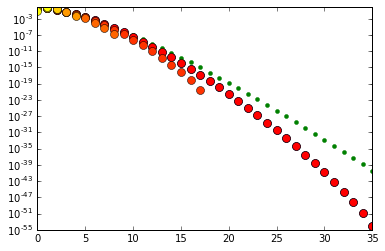

In [23]:
plt.plot(binom.pmf(np.arange(N0/2+1), N0/2, 2/N0), 'bo', ms=8, label='binom pmf')
plt.plot(poisson.pmf(np.arange(N0/2+1), 1), 'g.', ms=8, label='binom pmf')
for i,a in enumerate(2**np.arange(6)):
    plt.plot(binom.pmf(np.arange(N0/a/2+1), N0/a/2, 2*a/N0), 'o', color=plt.cm.autumn(i/5.), ms=8, label='binom pmf')
plt.yscale('log')

If the electrostatic blob cannot contain even the shortest side chain, then every side chain sticks out and thus the branching counts as a cross link. The precise boundary is when the electrostatic blob contains the main chain and a single monomeric side chain $ge<2N_0$. This translates in a condition on $A$ (provided $\tau$):
$$A < A_1 = \left(\frac{2N_0 u}{\tau}\right)^{1/2}$$.

In [24]:
(2*N0*u/np.array([0.2,tau,0.5,1]))**(1/2)

array([ 43.41215711,  33.79631847,  27.45625892,  19.41450687])

Since there is exactly one head per body, the average number of heads attached to a given body is 1. The probability to have a head attached to a monomer is thus $1/N_0$. The probability of having a given number of monomers between crosslinks is thus given by a geometric distribution of parameter $1/N_0$. The average number of monomers between crosslinks is thus $N_0$. Therefore $n=k=1$.

If $A>A_1$, monomeric side chains are able to fully collapse on the main chain and thus do not count as cross-link anymore. The probability to have a crosslink is thus the probability to have a side chain AND that this side chain is not monomeric.

Let us suppose that the probability of attaching a head to a given body is ndependent of the number of heads already attached, with a maximum of $N_0/2A$ heads per body (bivalent phosphonate head need two monovalent cationic groups to attach, and ony $N_0/A$ are available). The probability $P(h)$ of having $h$ heads attached to the same body is thus given by a binomial law of mean 1. The probability to have no head attached and thus a tail is 
$$P(h=0) = \left(1-\frac{2A}{N_0}\right)^{N_0/2A}$$

In [25]:
def P(h,A=1): 
    return binom.pmf(h, N0/2/A, 2*A/N0)
P(0)

0.36256054767581464

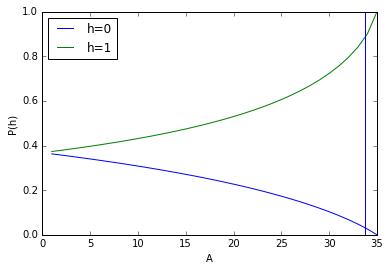

In [26]:
plt.plot(range(1,N0//2+1), [P(0, a) for a in range(1,N0//2+1)], label='h=0')
plt.plot(range(1,N0//2+1), [P(1, a) for a in range(1,N0//2+1)], label='h=1')
plt.xlabel('A')
plt.ylabel('P(h)')
plt.legend(loc='upper left')
plt.axvline((2*N0*u/tau)**(1/2))

The probability for a given monomer to hold a crosslink is thus
$$\frac{1-P(h=0)}{N_0}$$
The number of monomers betwenn crosslinks is the inverse of the latter. Finally, the number of chains between crosslinks is 
$$n = \frac{1}{1-P(h=0)}$$

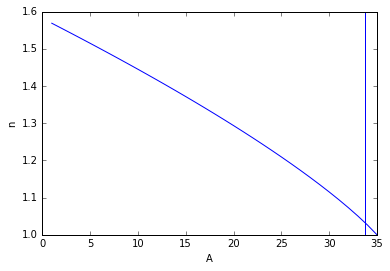

In [27]:
plt.plot(range(1,N0//2+1), [1/(1-P(0, a)) for a in range(1,N0//2+1)])
plt.xlabel('A')
plt.ylabel('n')
plt.axvline((2*N0*u/tau)**(1/2))

In [28]:
1/(1-P(0))

1.5687764482632396

There is also a threshold $A_2 = \left(\frac{3N_0 u}{\tau}\right)^{1/2}$ when a dimeric side chains can collapse on the main chain. For $A>A_2$
$$n = \frac{1}{1-P(h=0)-P(h=1)P(h=0)}$$

In [29]:
1/(1-P(0) - P(0)*P(1))

1.9915434258974904

For $A>A_3$
$$n = \frac{1}{1 - P(h=0) - P(h=1)\left(P(h=0)+P(h=1)P(h=0)\right) - P(h=2)P(h=0)^2}$$

In [30]:
1/(1 - P(0)*(1 + P(1) + P(1)**2) - P(0)**2*P(2)*(1+2*P(1)))

2.4463089358439283

In [31]:
1/(1 - P(0)*(1 + P(1) + P(1)**2 + P(1)**3) - P(0)**2*P(2)*(1+2*P(1)+3*P(1)**2) - P(0)**3*P(3))

2.6539150687299284

A single head attached and thus a linear procession has probability of P(h=1)

In [32]:
binom.pmf(1, N0/2, 2/N0)

0.37322409319569066

And the probability to branch is $P(h\geq 2)$

In [33]:
1 - np.sum(binom.pmf([0,1], N0/2, 2/N0))

0.2642153591284947

Therefore, the number of chains beween cross links n=k is

In [34]:
1/(1-np.sum(binom.pmf([0,1], N0/2, 2/N0)))

3.7847913281743564

More complete expression taking into account the probability to have a second branching (third head) on the same 
$$\frac{P(h=2) \times 1/P(h\geq 2) + P(h>3)}{P(h\geq 2)}$$

In [35]:
(binom.pmf(2, N0/2, 2/N0) / (1-np.sum(binom.pmf([0,1], N0/2, 2/N0))) + (1-np.sum(binom.pmf([0,1,2], N0/2, 2/N0)))) / (1-np.sum(binom.pmf([0,1], N0/2, 2/N0)))

2.9668637387798635

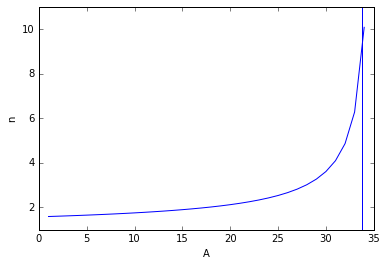

In [36]:
plt.plot(range(1,N0//2), [1/(1-P(1,a)) for a in range(1,N0//2)])
plt.xlabel('A')
plt.ylabel('n')
plt.axvline((2*N0*u/tau)**(1/2))

$N_0/A$ is not actually a hard upper bound to the number of possible sites on a chain. The number of charges on a given chain follows a binomial law of mean $N_0/A$ and upper bound $N_0$. We have to combine this and the previous law giving the probability distribution of the number of heads knowing the number of charges.
$$P(h,A) = \sum_{i=0}^{N_0} P(h|i)P(i,A)$$

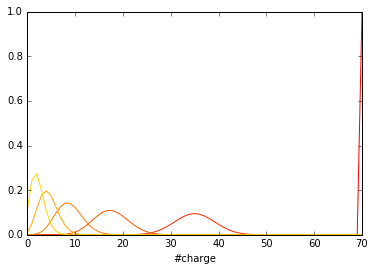

In [37]:
for a in 2**np.arange(6):
    plt.plot(np.arange(N0+1), binom.pmf(np.arange(N0+1), N0, 1/a), color=plt.cm.autumn(np.log2(a)/6))
plt.xlabel('#charge')

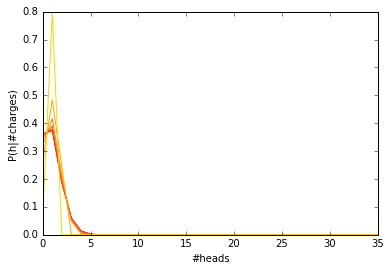

In [38]:
i=70
for i in N0/2**np.arange(6):
    plt.plot(range(N0//2+1), binom.pmf(np.arange(N0//2+1), i/2, 2/i), color=plt.cm.autumn(np.log2(N0/i)/6))
plt.xlabel('#heads')
plt.ylabel('P(h|#charges)')

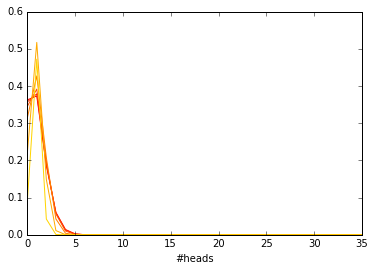

In [39]:
for a in 2**np.arange(6):
    Pcharges = binom.pmf(np.arange(2,N0+1), N0, 1/a)
    plt.plot(
        range(N0//2+1), 
        [np.sum(Pcharges * np.array([binom.pmf(h, i/2, 2/i) for i in range(2,N0+1)])) for h in range(N0//2+1)],
        color=plt.cm.autumn(np.log2(a)/6)
    )
plt.xlabel('#heads')

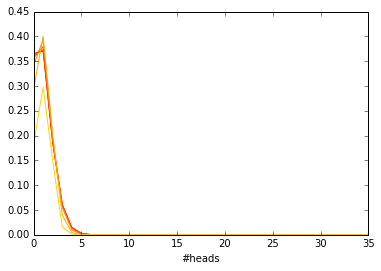

In [40]:
for a in 2**np.arange(6):
    Pcharges = binom.pmf(np.arange(2,N0+1), N0, 1/a)
    plt.plot(
        range(N0//2+1), 
        [np.sum(Pcharges * np.array([binom.pmf(h, i, 1/i) for i in range(2,N0+1)])) for h in range(N0//2+1)],
        color=plt.cm.autumn(np.log2(a)/6)
    )
plt.xlabel('#heads')

In [41]:
def P(h, A=1):
    Pcharges = binom.pmf(np.arange(1,N0+1), N0, 1/A)
    Pheads = np.array([binom.pmf(h, i/1, 1/i) for i in range(1,N0+1)])
    return np.sum(Pheads * Pcharges, -1)

In [42]:
P(0)

0.36523597711796002

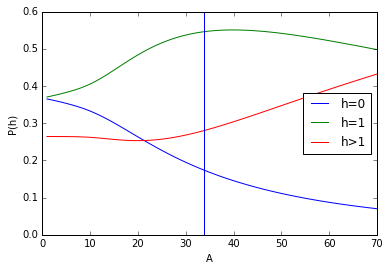

In [43]:
plt.plot(range(1,N0+1), [P(0, a) for a in range(1,N0+1)], label='h=0')
plt.plot(range(1,N0+1), [P(1, a) for a in range(1,N0+1)], label='h=1')
plt.plot(range(1,N0+1), [1-P(0,a)-P(1, a) for a in range(1,N0+1)], label='h>1')
plt.xlabel('A')
plt.ylabel('P(h)')
plt.legend(loc='center right')
plt.axvline((2*N0*u/tau)**(1/2))

(0, 2.5)

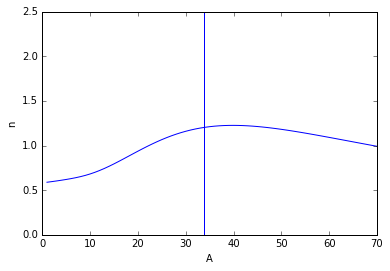

In [44]:
plt.plot(range(1,N0+1), [1/(1-P(1,a))-1 for a in range(1,N0+1)])
plt.xlabel('A')
plt.ylabel('n')
plt.axvline((2*N0*u/tau)**(1/2))
plt.ylim(0,2.5)

Probability to have 2 neighbouring charges for a given A.

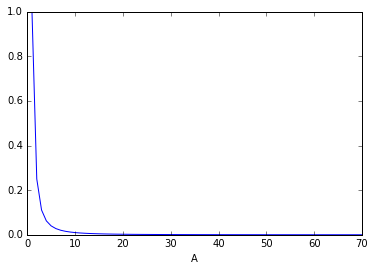

In [45]:
plt.plot(range(1,N0+1), [binom.pmf(2,2,1/a) for a in range(1,N0+1)])
plt.xlabel('A')

Distance beween two couples of neighbouring charges function of A

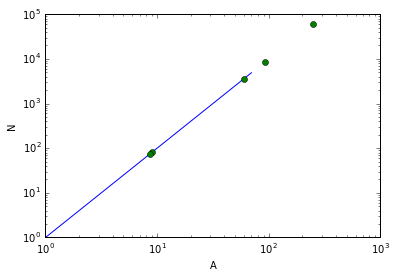

In [46]:
plt.plot(range(1,N0+1), [1/binom.pmf(2,2,1/a) for a in range(1,N0+1)])
plt.xlabel('A')
plt.ylabel('N')
plt.xscale('log')
plt.yscale('log')
plt.plot(np.sqrt(n*N0), n*N0, 'o')

In [47]:
2/N0**2

0.00040816326530612246

In [50]:
(2*u*N0/np.arange(2,11)*10)**0.5

array([ 43.41215711,  35.44587785,  30.69703068,  27.45625892,
        25.06402059,  23.20477404,  21.70607855,  20.46468712,  19.41450687])